In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# !wget https://huggingface.co/datasets/malay-huggingface/pembalakan/resolve/main/ign_dataset.zip
# !unzip ign_dataset.zip
# !rm ign_dataset.zip

In [3]:
from glob import glob

In [4]:
train_X = glob('ign/images/training/*.png')
train_Y = glob('ign/annotations/training/*.png')
len(train_X), len(train_Y)

(600, 600)

In [5]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
import tensorflow as tf

Segmentation Models: using `tf.keras` framework.


In [6]:
import segmentation_models as sm
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [7]:
def preprocess_input(x):
    x = x.astype(np.float32)
    x /= 255.
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    x[..., 0] /= std[0]
    x[..., 1] /= std[1]
    x[..., 2] /= std[2]
    return x

def sometimes(aug): return iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    sometimes(iaa.Affine(rotate=(-90, 90))),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Add((-5, 5)),
    sometimes(iaa.Clouds()),
    iaa.CropToFixedSize(width=384, height=384),
    sometimes(iaa.MotionBlur(k=3, angle=[-45, 45])),
], random_order=True)

In [8]:
x = imread(train_X[0])
y = imread(train_X[0].replace('/images', '/annotations'))
np.unique(y)

array([1, 2, 3, 6], dtype=uint8)

In [9]:
segmap = SegmentationMapsOnImage(y.astype(np.int32), shape=x.shape)

In [10]:
img = x.astype(np.uint8)
images_aug_i, segmaps_aug_i = seq(image=img, segmentation_maps=segmap)

In [11]:
mask = segmaps_aug_i.get_arr()
image = images_aug_i
image = preprocess_input(image)

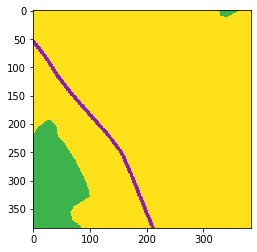

In [12]:
plt.imshow(segmaps_aug_i.draw()[0])

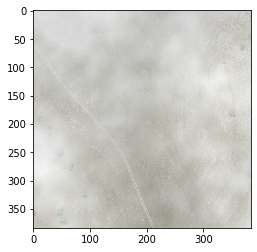

In [13]:
plt.imshow(images_aug_i)

In [14]:
from tensorflow.keras.layers import concatenate

def convolution_block(x, filters, size, strides=(1, 1), padding='same', activation=True, training=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x


def residual_block(blockInput, num_filters=16, training=True):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput, training=training)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = tf.math.add(x, blockInput)
    return x

In [16]:
from convnext import ConvNeXt, model_configs

img_size=384
num_classes=1000
include_top=False
cfg = model_configs['convnext_small']
net = ConvNeXt(num_classes, cfg['depths'],
                   cfg['dims'], include_top)
X = tf.placeholder(tf.float32, (None, img_size, img_size, 3))
tf.keras.layers.Input(tensor=X)
backbone = out = net(X)
backbone = tf.keras.Model(X, out)

In [17]:
backbone.layers[0]

In [18]:
backbone.layers[1].layers[2].layers[1].output

<tf.Tensor 'conv_ne_xt_1/sequential_10/conv2d_6/BiasAdd:0' shape=(?, 24, 24, 384) dtype=float32>

In [19]:
for i in range(len(backbone.layers[1].layers)):
    print(i, backbone.layers[1].layers[i])
    for k in range(len(backbone.layers[1].layers[i].layers)):
        print(i, k, backbone.layers[1].layers[i].layers[k].output)
    print()

0 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7ce0582208>
0 0 Tensor("conv_ne_xt_1/sequential_8/conv2d_4/BiasAdd:0", shape=(?, 96, 96, 96), dtype=float32)
0 1 Tensor("conv_ne_xt_1/sequential_8/layer_normalization_40/batchnorm/add_1:0", shape=(?, 96, 96, 96), dtype=float32)

1 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7ce0582a58>
1 0 Tensor("conv_ne_xt_1/sequential_9/layer_normalization_41/batchnorm/add_1:0", shape=(?, 96, 96, 96), dtype=float32)
1 1 Tensor("conv_ne_xt_1/sequential_9/conv2d_5/BiasAdd:0", shape=(?, 48, 48, 192), dtype=float32)

2 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7ce0588278>
2 0 Tensor("conv_ne_xt_1/sequential_10/layer_normalization_42/batchnorm/add_1:0", shape=(?, 48, 48, 192), dtype=float32)
2 1 Tensor("conv_ne_xt_1/sequential_10/conv2d_6/BiasAdd:0", shape=(?, 24, 24, 384), dtype=float32)

3 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7ce0588a58>
3 0 Tensor("conv

In [20]:
class Model:
    def __init__(self, img_size=384, dropout_rate=0.25, training=True, output_size = 1):
        self.backbone = backbone
        start_neurons = 16

        # [B, 12, 12, 768]
        conv4 = backbone.layers[1].layers[3].layers[1].output
        conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
        pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
        pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4, training=training)
        # [B, 6, 6, 768]

        # [B, 6, 6, 512]
        convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
        convm = residual_block(convm, start_neurons * 32, training=training)
        convm = residual_block(convm, start_neurons * 32, training=training)
        # [B, 6, 6, 512]
        convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)

        # [B, 12, 12, 256]
        deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
        uconv4 = concatenate([deconv4, conv4])
        # [B, 12, 12, 1024]
        uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4, training=training)

        # [B, 12, 12, 256]
        uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
        uconv4 = residual_block(uconv4, start_neurons * 16)
        uconv4 = residual_block(uconv4, start_neurons * 16)
        # [B, 12, 12, 256]
        uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)

        # [B, 24, 24, 128]
        deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
        # [B, 24, 24, 384]
        conv3 = backbone.layers[1].layers[2].layers[1].output
        # [B, 24, 24, 512]
        uconv3 = concatenate([deconv3, conv3])
        uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3, training=training)

        # [B, 24, 24, 128]
        uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
        uconv3 = residual_block(uconv3, start_neurons * 8)
        uconv3 = residual_block(uconv3, start_neurons * 8)
        # [B, 24, 24, 128]
        uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

        # [B, 48, 48, 64]
        deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
        # [B, 48, 48, 192]
        conv2 = backbone.layers[1].layers[1].layers[1].output
        # [B, 48, 48, 256]
        uconv2 = concatenate([deconv2, conv2])
        uconv2 = tf.keras.layers.Dropout(0.1)(uconv2, training=training)

        # [B, 48, 48, 64]
        uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
        uconv2 = residual_block(uconv2, start_neurons * 4, training=training)
        uconv2 = residual_block(uconv2, start_neurons * 4, training=training)
        uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
        
        # [B, 96, 96, 32]
        deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
        # [B, 96, 96, 96]
        conv1 = backbone.layers[1].layers[0].layers[1].output
        # [B, 96, 96, 128]
        uconv1 = concatenate([deconv1, conv1])
        uconv1 = tf.keras.layers.Dropout(0.1)(uconv1, training=training)

        # [B, 192, 192, 16]
        uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)
        uconv0 = tf.keras.layers.Dropout(0.1)(uconv0, training=training)
        uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
        uconv0 = residual_block(uconv0, start_neurons * 1, training=training)
        uconv0 = residual_block(uconv0, start_neurons * 1, training=training)
        uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
        
        # [B, 384, 384, 16]
        uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv0)
        uconv0 = tf.keras.layers.Dropout(0.1)(uconv0, training=training)
        uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
        uconv0 = residual_block(uconv0, start_neurons * 1, training=training)
        uconv0 = residual_block(uconv0, start_neurons * 1, training=training)
        uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)

        uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0, training=training)
        activation = 'softmax' if output_size > 1 else 'sigmoid'
        self.logits = tf.keras.layers.Conv2D(output_size, (1, 1), padding="same", 
                                             activation=activation)(uconv0)

In [21]:
model = Model()

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
sess.run(model.logits, feed_dict = {X: [image]}).shape

(1, 384, 384, 1)